In [1]:
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.multiprocessing
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
GLOBAL_SEED = 42  # number of life
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
#load users data
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
#load movies data
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='ISO-8859-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#load ratings data
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings["Rating"] = ratings["Rating"] - 3  # rating range (-2, 2)
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,2,978300760
1,1,661,0,978302109
2,1,914,0,978301968
3,1,3408,1,978300275
4,1,2355,2,978824291


In [6]:
#split train-test set
train_ratings, validation_ratings = train_test_split(
    ratings, test_size=0.1, random_state=42
)
users_in_validation = validation_ratings["UserID"].unique()
all_users = users["UserID"].unique()

print(f"There are {len(users_in_validation)} users in validation set.")
print(f"Total number of users: {len(all_users)}")

There are 5970 users in validation set.
Total number of users: 6040


In [7]:
# map movie id and user id to indexes.
movie_index_by_id = {id: idx for idx, id in enumerate(movies["MovieID"])}
user_index_by_id = {id: idx for idx, id in enumerate(users["UserID"])}


class MLDataset(Dataset):
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, index):
        user_id = self.ratings["UserID"].iloc[index]
        movie_id = self.ratings["MovieID"].iloc[index]
        rating = self.ratings["Rating"].iloc[index]
        user_index = user_index_by_id[user_id]
        movie_index = movie_index_by_id[movie_id]
        return user_index, movie_index, rating


training_data = MLDataset(train_ratings)
validation_data = MLDataset(validation_ratings)
batch_size = 1024
train_dataloader = DataLoader(
    training_data, batch_size=batch_size, shuffle=True, num_workers=8
)
validation_dataloader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=False, num_workers=8
)

In [8]:
LR = 1
WEIGHT_DECAY = 5e-5


class MatrixFactorization(pl.LightningModule):
    """Pytorch lighting class for Matrix Factorization training.

    Attributes:
        n_users: number of users.
        n_items: number of items.
        n_factors: number of latent factors (or embedding size)
    """

    def __init__(self, n_users: int, n_items: int, n_factors: int = 40):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_biases = nn.Embedding(n_users, 1)
        self.item_biases = nn.Embedding(n_items, 1)
        self.bias = nn.Parameter(data=torch.rand(1))
        self.user_embeddings = nn.Embedding(n_users, n_factors)
        self.item_embeddings = nn.Embedding(n_items, n_factors)

    def forward(self, users, items):
        """
        Forward pass through the model. For a single user and item, this
        looks like:
        bias + user_bias + item_bias + user_embeddings.dot(item_embeddings)

        Arguments:
            users: Array of user indices
            items : Array of item indices
        Returns:
            preds: Predicted ratings.
        """
        # select users and items from the batch
        batch_user_embs = self.user_embeddings(users)
        batch_item_embs = self.item_embeddings(items)

        preds = torch.reshape(
            torch.diag(
                torch.matmul(batch_user_embs, torch.transpose(batch_item_embs, 0, 1))
            ),
            (-1, 1),
        )
        # add bias
        preds += self.user_biases(users) + self.item_biases(items) + self.bias

        return torch.clip(preds.squeeze(), min=-2, max=2)

    def training_step(self, batch, batch_idx):
        users, items, rating = batch
        rating = rating.to(torch.float32)
        output = self.forward(users, items)
        loss = F.mse_loss(rating, output)
        self.log("batch_loss", loss)
        return {"loss": loss}  # for computing avg_loss in training_epoch_end

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        return optimizer

In [10]:
# for tensorboard
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("mf_tb_logs", name=f"lr{LR}_wd{WEIGHT_DECAY}")

n_users = len(user_index_by_id)
n_movies = len(movie_index_by_id)
n_factors = 40
model = MatrixFactorization(n_users=n_users, n_items=n_movies, n_factors=n_factors)
trainer = pl.Trainer(accelerator='cpu', max_epochs=100, logger=logger)
trainer.fit(model, train_dataloader, validation_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mvtuong/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
2023-12-22 00:54:36.587446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 00:54:37.009006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 00:54:45.279619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name            | Type      | Params
----------------------------------------------
0 |

Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [11]:
def eval_model(model, train_dataloader):
    loss = 0
    for users, items, rating in train_dataloader:
        pred = model(users, items)
        loss += F.mse_loss(pred, rating)
    RMSE = (loss / len(train_dataloader))**.5
    return RMSE
    
print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))
print("Validation RMSE: {:.3f}".format(eval_model(model, validation_dataloader)))

Train RMSE: 0.797
Validation RMSE: 0.880


In [12]:
torch.save(model.state_dict(), './model/movie-recommendation/matrix_factorization.pth')

In [9]:
#load trained model
n_users = len(user_index_by_id)
n_movies = len(movie_index_by_id)
n_factors = 40
model = MatrixFactorization(n_users=n_users, n_items=n_movies, n_factors=n_factors)
model.load_state_dict(torch.load('./model/movie-recommendation/matrix_factorization.pth'))
model.eval()

MatrixFactorization(
  (user_biases): Embedding(6040, 1)
  (item_biases): Embedding(3883, 1)
  (user_embeddings): Embedding(6040, 40)
  (item_embeddings): Embedding(3883, 40)
)

In [23]:
import matplotlib.pyplot as plt

#visualize test result
# actual = np.zeros(len(validation_ratings))
# predictions = np.zeros(len(validation_ratings))
# actual = np.zeros(100)
# predictions = np.zeros(100)
pred_tmp = []
actual_tmp = []
with torch.no_grad():
    for users, items, rating in validation_dataloader:
        pred = model(users, items)
        pred_tmp.append(pred.cpu().numpy() + 2)
        actual_tmp.append(rating.cpu().numpy() + 2)

In [30]:
actual = actual_tmp[0][:100]
predictions = pred_tmp[0][:100]

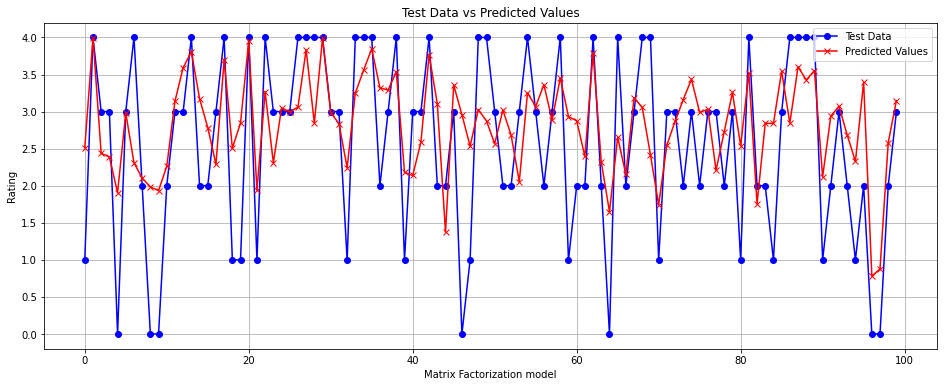

In [32]:
# x_point = range(0, len(validation_ratings))
x_point = range(0, 100)
plt.figure(figsize=(16, 6))
# Plotting test data
plt.plot(x_point, actual, marker='o', color='blue', label='Test Data')
# Plotting predicted values
plt.plot(x_point, predictions, marker='x', color='red', label='Predicted Values')
plt.xlabel('Matrix Factorization model')
plt.ylabel('Rating')
plt.title('Test Data vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()